# 의사결정 트리 모델 적용 실습

# 온라인 광고 클릭 예측 모델 만들기

## 데이터 개요

* CTR : Click-Through Rate. 전체 페이지 뷰 횟수 대비 특정 광고를 클릭한 횟수의 비율
* Click-Through 예측이란 어떤 사용자가 현재 보고 있는 웹 페이지에 노출된 광고를 클릭할지를 예측하는 이진 분류 문제
* Kaggle 온라인 광고 클릭 예측 모델을 위한 데이터셋
* train.csv - 시간 순으로 정렬된 10일 간의 Click-Through 예측을 위한 데이터
<br><br>
id: ad identifier   <br>
`click: 0/1 for non-click/click  --> 대상벡터 = 출력변수 = 반응변수` <br>
hour: format is YYMMDDHH, so 14091123 means 23:00 on Sept. 11, 2014 UTC.<br>
C1 -- anonymized categorical variable<br>
banner_pos<br>
site_id<br>
site_domain<br>
site_category<br>
app_id<br>
app_domain<br>
app_category<br>
device_id<br>
device_ip<br>
device_model<br>
device_type<br>
device_conn_type<br>
C14-C21 -- anonymized categorical variables<br>

## 데이터 준비

In [48]:
import pandas as pd

train_df = pd.read_csv('train', nrows=100000)  
unused_columns, label_column = ['id', 'hour', 'device_id', 'device_ip'], 'click' # 사용하지 않을 Columns, label Column 지정

# 훈련용 데이터 생성
train_df = train_df.drop(unused_columns, axis=1)
X_dict_train = list(train_df.drop(label_column, axis=1).T.to_dict().values()) # 특징행렬을 만들기 전에, df->dictionary 형태로 바꾸어 그 안의 values만 추출
X_dict_train[0] # 
y_train = train_df[label_column] # 대상벡터

In [49]:
# 평가용 데이터 생성
test_df = pd.read_csv('train', header=0, skiprows=(1, 100000), nrows=100000) # 1 ~ 100,000행은 앞서 읽어왔기 때문에 그 부분을 skip.
test_df = test_df.drop(unused_columns, axis=1)
X_dict_test = list(test_df.drop(label_column, axis=1).T.to_dict().values())
y_test = test_df[label_column]

## One-Hot Encoding 벡터 변환

자연어를 컴퓨터가 처리하도록 하기 위해서 숫자로 바꾸는 방법을 알아야 한다. <br>
문자를 기계가 이해할 수 있는 숫자로 바꾼 결과 또는 그 과정을 임베딩(Embedding)이라고 한다. <br>
가장 간단한 형태의 임베딩은 문장에 어떤 단어가 많이 쓰였는지를 파악하여 글쓴이의 의도를 알 수 있다. <br>
원-핫 인코딩(One-Hot Encoding)은 여러 기법 중 단어를 표현하는 가장 기본적인 표현 방법이다.<br>

<u>scikit-learn의 트리 기반의 모델들의 중요한 특징은 입력 변수로 사용하는 특징을 모두 수치로 쓴다는 것.</u>

원 핫 인코딩 벡터 변환 방법이 다양한데 dictionary로 변환한 이유는 일괄 적용하기 위함.

In [50]:
from sklearn.feature_extraction import DictVectorizer

# vectorizing할 때, 이진 변환하니까 0이 무수히 많이 생긴다.
# 0이 무수히 많아지면 메모리 낭비가 심해지기 때문에, 희소 행렬 형태로 작업해야 메모리 문제를 해결할 수 있다.
vectorizer = DictVectorizer(sparse=True) 

# 훈련용 데이터에 대해 One-Hot Encoding 벡터 변환
X_train = vectorizer.fit_transform(X_dict_train)
X_train.shape  # 19차원에서 4952차원으로 늘어남. (범주형 데이터를 이진 변환했기 때문)

(100000, 4952)

In [51]:
X_train.toarray()[:5] # 희소행렬이 아닌 정상적인 행렬 형태로 다시 변환.

array([[ 1005., 15706.,   320., ...,     0.,     0.,     0.],
       [ 1005., 15704.,   320., ...,     0.,     0.,     0.],
       [ 1005., 15704.,   320., ...,     0.,     0.,     0.],
       [ 1005., 15706.,   320., ...,     0.,     0.,     0.],
       [ 1005., 18993.,   320., ...,     0.,     0.,     0.]])

In [52]:
# 평가용 데이터에 대해서도 One-Hot Encoding 벡터 변환
X_test = vectorizer.fit_transform(X_dict_test) 
X_train.toarray()[:5]

array([[ 1005., 15706.,   320., ...,     0.,     0.,     0.],
       [ 1005., 15704.,   320., ...,     0.,     0.,     0.],
       [ 1005., 15704.,   320., ...,     0.,     0.,     0.],
       [ 1005., 15706.,   320., ...,     0.,     0.,     0.],
       [ 1005., 18993.,   320., ...,     0.,     0.,     0.]])

## GridSearchCV를 이용한 의사결정 트리 모델 학습

In [53]:
from sklearn.tree import DecisionTreeClassifier

parameters = {'max_depth' : [3, 10, None]}
decision_tree = DecisionTreeClassifier(criterion='gini', min_samples_split=30)


In [54]:
from sklearn.model_selection import GridSearchCV

# n_jobs = -1 --> 모든 processor 사용
# scoring='roc_auc' --> 분류 평가 지표 중 하나.
grid_search = GridSearchCV(decision_tree, parameters, n_jobs=-1, cv=3, scoring='roc_auc')

In [58]:
# GridSearch를 이용해 적합화시키기
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(min_samples_split=30),
             n_jobs=-1, param_grid={'max_depth': [3, 10, None]},
             scoring='roc_auc')

In [63]:
decision_tree_best = grid_search.best_params_
decision_tree_best

# max_depth : 10 이 best result..

{'max_depth': 10}

In [64]:
# Create an instance of DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(max_depth=10)

# Fit the decision tree classifier on your training data
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10)

## 의사결정 트리 모델의 파일 출력

In [65]:
from sklearn.tree import export_graphviz

# class_names=['0', '1'] --> 0 : 클릭x, 1 : 클릭 
export_graphviz(
    decision_tree, out_file='ctr_decision_tree.dot', \
    feature_names=vectorizer.feature_names_, \
    class_names=['0', '1'], rounded=True, filled=True, impurity=True
)


In [67]:
import pydot 

graph = pydot.graph_from_dot_file('ctr_decision_tree.dot')[0]
graph.write_png('ctr_decision_tree.png')

# 온라인 광고 클릭 예측 모델 성능 측정

## 1. 혼동행렬

* 실제 관측값을 얼마나 정확하게 예측했는지를 보여주는 행렬
* True Positive : 예측 'true', 실제 'true'
* True Negative : 예측 'false', 실제 'false'
* False Positive : 예측 'true', 실제 'false'  (1형 오류)
* False Negative : 예측 'false', 실제 'true'  (2형 오류)
* 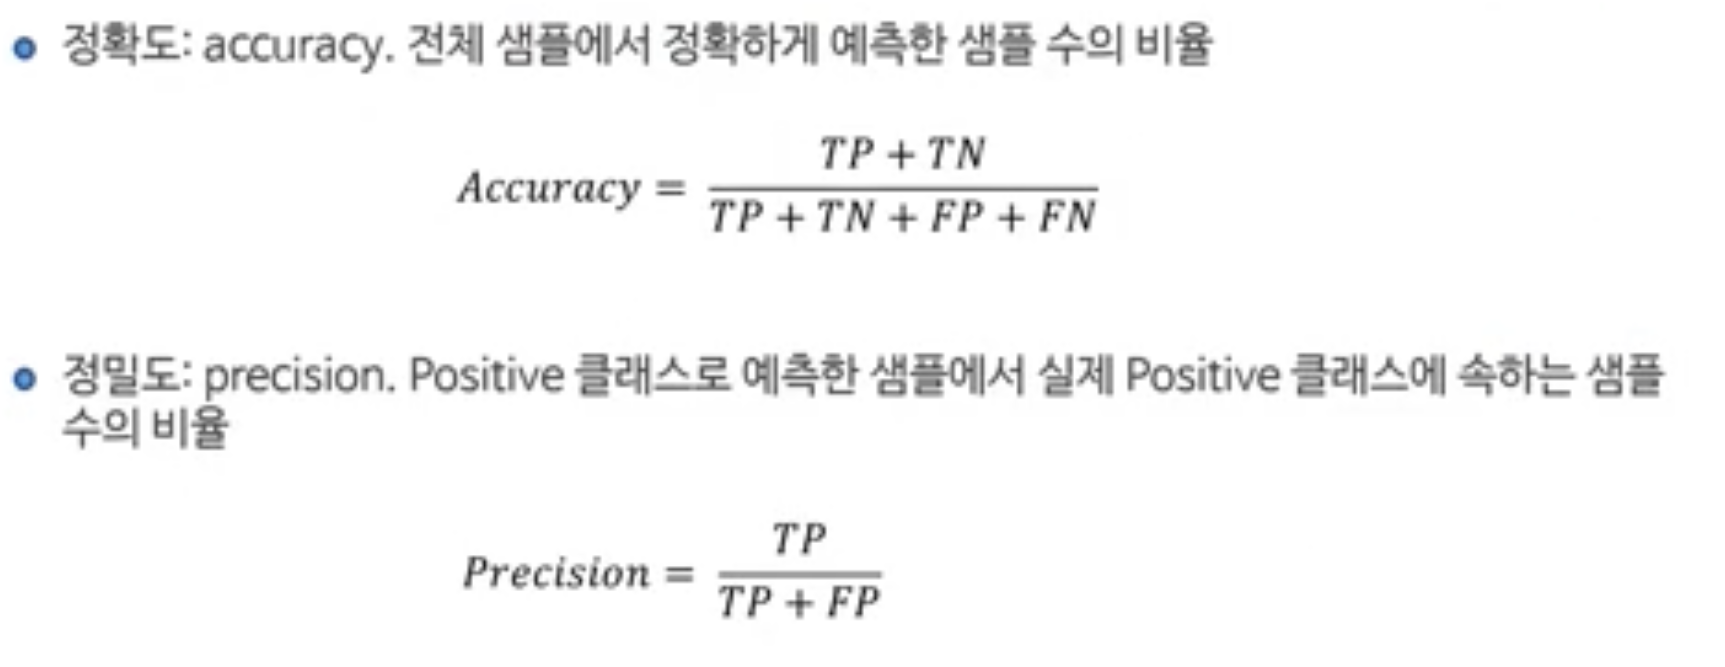
* 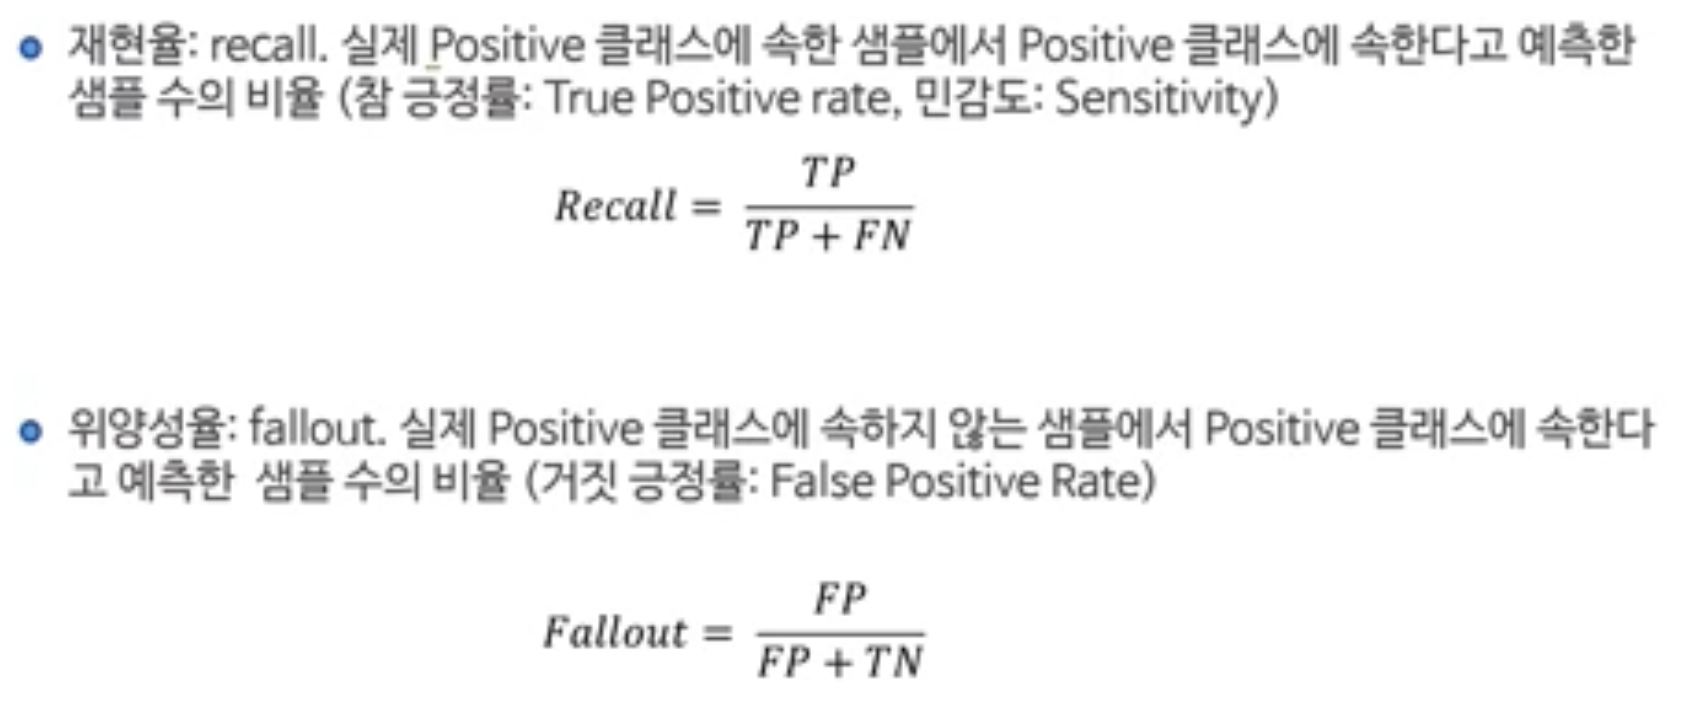

`F1 점수`
* 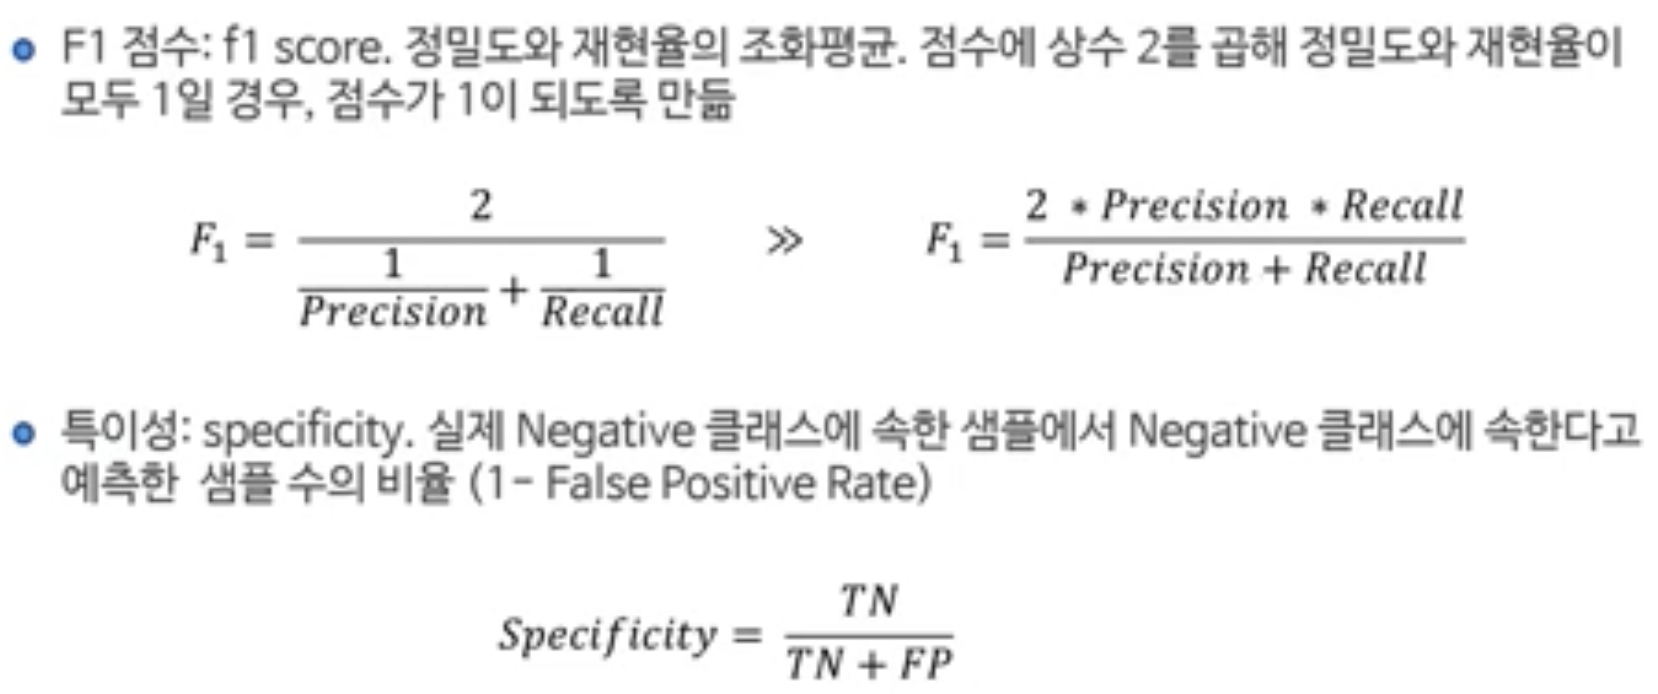

`AUC` 
* 참 긍정률(TPR)과 거짓 부정률(FPR) 사이를 표현하기 위해 ROC(Receiver Operating Characteristics) 커버를 사용
* 예측된 확률로부터 여러 클래스로 분류를 수행하는 데 활용
* ROC Curve가 되도록 모델을 개선시켜야 한다.
* 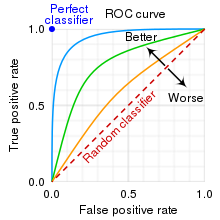

## 성능 측정 : 정확도, 오차행렬, ROC의 AUC

In [70]:
from sklearn.tree import DecisionTreeClassifier

# Create an instance of DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(max_depth=10)

# Fit the decision tree classifier on your training data
decision_tree.fit(X_train, y_train)

# Make predictions on your test data
y_pred = decision_tree.predict(X_test)


y_pred = decision_tree.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [72]:
import numpy as np

np.unique(y_pred, return_counts=True)

(array([0, 1]), array([96564,  3436]))

In [73]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.83284

In [74]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[81179,  1331],
       [15385,  2105]])

In [76]:
from sklearn.metrics import roc_auc_score, roc_curve

y_pred_proba = decision_tree.predict_proba(X_test)[:, 1]
y_pred_proba

array([0.20767654, 0.13114754, 0.24324324, ..., 0.11586207, 0.06559647,
       0.06559647])

In [78]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

In [79]:
auc = roc_auc_score(y_test, y_pred_proba)

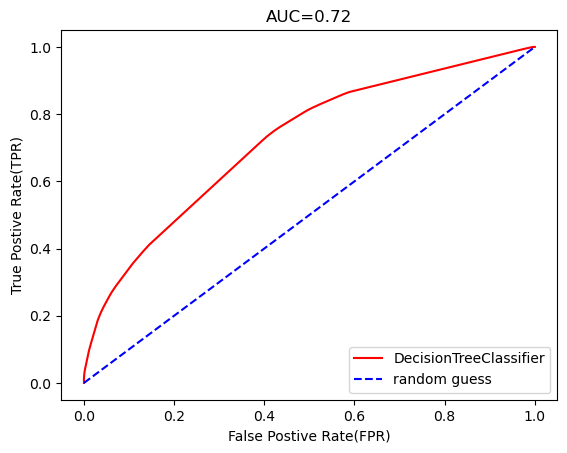

In [80]:
import matplotlib.pyplot as plt 

plt.plot(fpr, tpr, 'r-', label='DecisionTreeClassifier')
plt.plot([0, 1], [0, 1], 'b--', label='random guess')
plt.xlabel('False Postive Rate(FPR)')
plt.ylabel('True Postive Rate(TPR)')
plt.title("AUC={0:.2f}" .format(auc))
plt.legend(loc='lower right')

## 2. 앙상블